In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [4]:
DATA_PATH = "../data/processed/final_mine_data.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,timestamp,zone_id,vibration_energy,vibration_entropy,acoustic_energy,acoustic_hit_rate,stress_index,soil_type,excavation_depth,base_geotech_risk,risk_label
0,2026-01-20 13:40:16.007060+00:00,Z1,1294.493529,11.332929,51.749198,7.650625,0.265062,rock,20,0,0
1,2026-01-20 13:41:16.007060+00:00,Z1,1285.716775,11.186969,47.257973,7.714196,0.271420,rock,20,0,0
2,2026-01-20 13:42:16.007060+00:00,Z1,1330.537318,11.805865,50.507939,8.034114,0.303411,rock,20,0,0
3,2026-01-20 13:43:16.007060+00:00,Z1,1330.544053,11.690164,51.677189,7.970798,0.297080,rock,20,0,0
4,2026-01-20 13:44:16.007060+00:00,Z1,1316.414710,11.197017,46.731825,7.727588,0.272759,rock,20,0,0


In [5]:
FEATURE_COLS = [
    "vibration_energy",
    "vibration_entropy",
    "acoustic_energy",
    "acoustic_hit_rate",
    "stress_index",
    "excavation_depth"
]

X = df[FEATURE_COLS].values
X.shape

(900, 6)

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
X_train, X_val = train_test_split(
    X_scaled,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_val.shape

((720, 6), (180, 6))

In [8]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))

encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(8, activation="relu")(encoded)

decoded = Dense(16, activation="relu")(encoded)
decoded = Dense(input_dim, activation="linear")(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 16)                112       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dense_3 (Dense)             (None, 6)                 102       
                                                                 
Total params: 494 (1.93 KB)
Trainable params: 494 (1.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
autoencoder.compile(
    optimizer="adam",
    loss="mse"
)

In [10]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
23/23 [==============================] - 0s 3ms/step - loss: 1.5169 - val_loss: 1.1628
Epoch 2/50
23/23 [==============================] - 0s 696us/step - loss: 1.0927 - val_loss: 0.8596
Epoch 3/50
23/23 [==============================] - 0s 650us/step - loss: 0.7902 - val_loss: 0.6169
Epoch 4/50
23/23 [==============================] - 0s 644us/step - loss: 0.5673 - val_loss: 0.4828
Epoch 5/50
23/23 [==============================] - 0s 637us/step - loss: 0.4577 - val_loss: 0.4131
Epoch 6/50
23/23 [==============================] - 0s 662us/step - loss: 0.3976 - val_loss: 0.3651
Epoch 7/50
23/23 [==============================] - 0s 663us/step - loss: 0.3518 - val_loss: 0.3220
Epoch 8/50
23/23 [==============================] - 0s 667us/step - loss: 0.3070 - val_loss: 0.2769
Epoch 9/50
23/23 [==============================] - 0s 658us/step - loss: 0.2608 - val_loss: 0.2291
Epoch 10/50
23/23 [==============================] - 0s 659us/step - loss: 0.2135 - val_loss: 0.1851
E

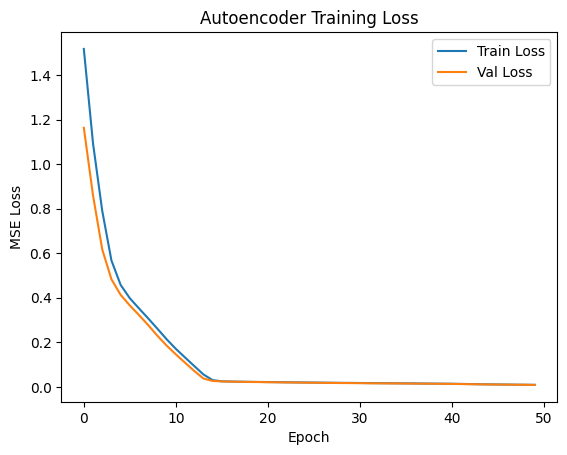

In [11]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss")
plt.show()

In [12]:
X_recon = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(
    np.square(X_scaled - X_recon),
    axis=1
)

df["reconstruction_error"] = reconstruction_error
df.head()

29/29 [==============================] - 0s 309us/step


,timestamp,zone_id,vibration_energy,vibration_entropy,acoustic_energy,acoustic_hit_rate,stress_index,soil_type,excavation_depth,base_geotech_risk,risk_label,reconstruction_error
0,2026-01-20 13:40:16.007060+00:00,Z1,1294.493529,11.332929,51.749198,7.650625,0.265062,rock,20,0,0,0.021653
1,2026-01-20 13:41:16.007060+00:00,Z1,1285.716775,11.186969,47.257973,7.714196,0.271420,rock,20,0,0,0.001779
2,2026-01-20 13:42:16.007060+00:00,Z1,1330.537318,11.805865,50.507939,8.034114,0.303411,rock,20,0,0,0.002206
3,2026-01-20 13:43:16.007060+00:00,Z1,1330.544053,11.690164,51.677189,7.970798,0.297080,rock,20,0,0,0.006554
4,2026-01-20 13:44:16.007060+00:00,Z1,1316.414710,11.197017,46.731825,7.727588,0.272759,rock,20,0,0,0.006019


In [13]:
threshold = np.percentile(reconstruction_error, 95)
threshold

0.026662395780132377

In [14]:
df["ae_anomaly"] = (df["reconstruction_error"] > threshold).astype(int)

df[["zone_id", "reconstruction_error", "ae_anomaly"]].head(10)

,zone_id,reconstruction_error,ae_anomaly
0,Z1,0.021653,0
1,Z1,0.001779,0
2,Z1,0.002206,0
3,Z1,0.006554,0
4,Z1,0.006019,0
5,Z1,0.010117,0
6,Z1,0.002643,0
7,Z1,0.014948,0
8,Z1,0.014407,0
9,Z1,0.005914,0


In [15]:
autoencoder.save("../models/autoencoder_model")

df.to_csv("../data/processed/final_mine_with_ae.csv", index=False)

print("✅ Autoencoder trained and outputs saved")

INFO:tensorflow:Assets written to: ../models/autoencoder_model/assets


INFO:tensorflow:Assets written to: ../models/autoencoder_model/assets


✅ Autoencoder trained and outputs saved
